In [1]:
import ants
import numpy as np

In [2]:
fname1 = ants.get_ants_data('r16')
fname2 = ants.get_ants_data('r64')
print(fname1)
print(fname2)

/Users/mahdi/.antspy/r16slice.jpg
/Users/mahdi/.antspy/r64slice.jpg


In [3]:
img1 = ants.image_read(fname1)
img2 = ants.image_read(fname2)
print(img1)

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256)
	 Spacing    : (1.0, 1.0)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]



In [4]:
arr_4d = np.random.randn(70,70,70,10).astype('float32')
img_fmri = ants.from_numpy(arr_4d, has_components=True)
print(img_fmri)

# todo : tester aussi from_nibabel/ to_nibabel (-> .nii.gz)
#        nifti_to_ants

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 10
	 Dimensions : (70, 70, 70)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]



dict_keys(['segmentation', 'probabilityimages'])


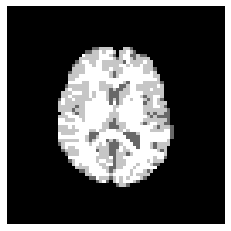

In [5]:
img = ants.image_read(ants.get_ants_data('r16'))
img = ants.resample_image(img, (64,64), 1, 0)
mask = ants.get_mask(img)
img_seg = ants.atropos(a=img, 
                       m='[0.2,1x1]', 
                       c='[2,0]', 
                       i='kmeans[3]', 
                       x=mask)
print(img_seg.keys())
ants.plot(img_seg['segmentation'])

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (64, 64)
	 Spacing    : (4.0476, 4.0476)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]



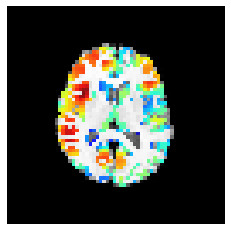

In [6]:
mg = ants.image_read( ants.get_ants_data('r16') ,2)
mask = ants.get_mask( img ).threshold_image( 1, 2 )
segs=ants.atropos( a = img, 
                   m = '[0.2,1x1]', 
                   c = '[2,0]',  
                   i = 'kmeans[3]', 
                   x = mask )
thickimg = ants.kelly_kapowski(s=segs['segmentation'], 
                               g=segs['probabilityimages'][1],
                               w=segs['probabilityimages'][2], 
                               its=45, 
                               r=0.5, 
                               m=1)
print(thickimg)
img.plot(overlay=thickimg, overlay_cmap='jet')

# Transform manually template 

In [121]:
import nrrd
import nibabel as nib
import numpy as np
import os
from pathlib import Path

template_file = '/Users/mahdi/stage-2022-mahdi/src/allen_template_25.nii.gz'
template_ras_file = "/Users/mahdi/stage-2022-mahdi/src/allen_template_25_manualRAS.nii.gz"

resolution = 25
res_avgt_mm = 70 / 1e3
avgt_offset = np.array([-5.675, -8.79448, -8.450335, 0])

# Load and manually transform the template
vol = nib.load(template_file).get_fdata()

vol_ras = np.moveaxis(vol, (0,1,2), (1,2,0))
vol_ras = np.flip(vol_ras, axis=2)
vol_ras = np.flip(vol_ras, axis=1)

affine = np.eye(4) * res_avgt_mm

img_ras = nib.Nifti1Image(vol_ras, affine)
nib.save(img_ras, template_ras_file)

# load reference
avgt = nib.load('/Users/mahdi/stage-2022-mahdi/src/AVGT.nii.gz')
ref_vol = avgt.get_fdata()

# load moving
allen = nib.load('/Users/mahdi/stage-2022-mahdi/src/allen_template_25_manualRAS.nii.gz')
allen_vol = allen.get_fdata()


allen_vol = allen_vol.astype(float)
ref_vol = ref_vol.astype(float)

fixed = ants.from_numpy( ref_vol ).resample_image((164, 212, 158),1,0)
moving = ants.from_numpy( allen_vol ).resample_image((164, 212, 158),1,0)

fixed.plot_ortho()
moving.plot_ortho()
mytx = ants.registration(fixed=fixed , moving=moving, type_of_transform='SyN' )

warped_moving = ants.apply_transforms(fixed=fixed, moving=moving, 
                                          transformlist=mytx['fwdtransforms'])
fixed.plot_ortho_double(warped_moving)
affine_offset = affine.copy()
affine_offset[:,3] + avgt_offset

warped_vol = warped_moving.numpy()
# Saving the volume (nifti)
img = nib.Nifti1Image(warped_vol, affine_offset)
nib.save(img, '/Users/mahdi/stage-2022-mahdi/src/template_reg.nii.gz')

FileNotFoundError: No such file or no access: '/Users/mahdi/stage-2022-mahdi/src/allen_template_25.nii.gz'

In [101]:
warped_moving.shape

(164, 212, 158)

### essais nii nibabel ants

In [38]:
# todo : tester aussi from_nibabel/ to_nibabel (-> .nii.gz)
#        nifti_to_ants

import ants
import nrrd
import numpy as np

array, metadata = nrrd.read('/Users/mahdi/stage-2022-mahdi/src/average_template_25.nrrd')

img = ants.from_numpy(array) # convertir en float

orientation = ants.get_orientation(img)

print(orientation)

KeyError: 'uint16'

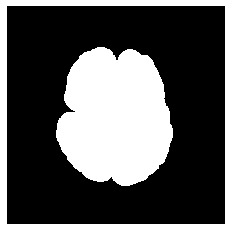

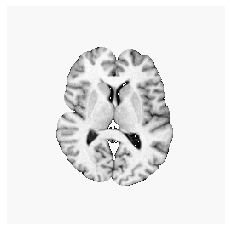

In [123]:
import ants
import numpy as np
import matplotlib.pyplot as plt

img = ants.image_read(ants.get_ants_data('r16'))
mask = ants.get_mask(img, cleanup=15, low_thresh=55)
ants.plot(mask)
nimg = img * mask
ants.plot(nimg,black_bg=False)


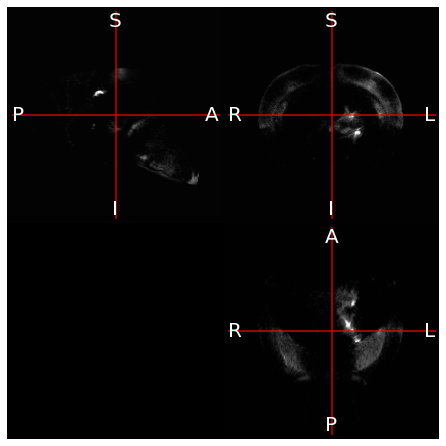

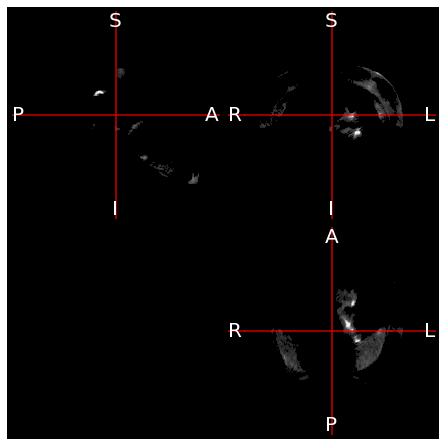

In [193]:
import numpy as np
import nibabel as nib


ants.ANTsImage.pixeltype = np.int32
img = nib.load('/Users/mahdi/stage-2022-mahdi/src/288169135_projection_density_50.nii.gz')

vol = img.get_fdata().astype(np.float32)

img = ants.from_numpy( vol ).resample_image((164, 212, 158),1,0)

img.plot_ortho()

for z in range(158):
    for y in range(212):
        for x in range(164):
            if vol[x, y, z] < 1e-01:
                vol[x, y, z] = 0.0

img = ants.from_numpy( vol )

img.plot_ortho()

 # Removing background 
    # mask = ants.get_mask(warped_moving)
    # warped_moving = warped_moving * mask



#####BINARIZED FORMULA######    S
    #warped_moving = warped_moving > 1e-01

In [53]:
import cv2

tmp = cv2.cvtColor(img.numpy(), cv2.COLOR_BGR2GRAY)
_,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
b, g, r = cv2.split(img.numpy())
rgba = [b,g,r, alpha]
dst = cv2.merge(rgba,4)


error: OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'
